In [69]:
import numpy as np
import os
from matplotlib import pyplot as plt 

from photutils import *
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [70]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

# World Coordinate System Definition 

In [71]:
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'NGC2324_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

In [72]:
temp_file_name = 'astrometric_obs_data/berkeley28_B_wcs.fits'

# --- Loading Relevant Files and Header Parameters --- 
hdulist = fits.open(temp_file_name)
tWCS = wcs.WCS(hdulist[0].header) #global variable
image_data = hdulist[0].data; print(np.shape(image_data))

target_name = temp_file_name[21:-8]
print(target_name)

(800, 850)
berkeley28_B_


## DAO Starfinder

Slight modfication used in the main body of the data-analysis. Basically identical, re-defined here for ease of use. 

In [73]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg'); plt.show()

    return mst_sources

## WCS Conversion 

In [74]:
def WCS_conversion(file_path):
    '''
    INPUT - .fits image for reading the WCS from the header, DAO Sources from a given image
    FUNCTION - Uses (x and y) centroid positions and the wcs to convert pixel values into RA and DEC (J2000)
    OUTPUT - An array of WCS values for each source in the fits file. where [n][0] - RA and [n][1] - DEC. And RA, DEC for centre-frame. 
    '''

    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header) # Parse the WCS keywords in the primary HDU
    data = hdulist[0].data

    DAO_sources  = starfinder(data, 6, False) # calling the star finder function 
    target_RADEC = []

    for idx in range(0, len(DAO_sources)):
        world = w.pixel_to_world(DAO_sources['xcentroid'][idx], DAO_sources['ycentroid'][idx])
        target_RADEC.append(world)

    centre =  w.pixel_to_world(np.shape(data)[0]/2, np.shape(data)[1]/2)
    
    return target_RADEC, centre, DAO_sources

def Pixel_conversion(RA, DEC, file_path): 
    coords = SkyCoord(RA, DEC, unit = 'deg')
    
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.world_to_pixel(coords)

def single_WCS_conversion(x_pix, y_pix, file_path): 
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.pixel_to_world(x_pix, y_pix)


In [75]:
tar, cnt, DAO_source_table = WCS_conversion(temp_file_name)
edge = single_WCS_conversion(0, 0, temp_file_name)
sep = cnt.separation(edge).degree

In [76]:
def APASS_query(frame_center):
    edge = tWCS.pixel_to_world(0, 0)
    query_radius = frame_center.separation(edge).degree # returns seperation in correct unit. 
    print(query_radius)

    return(Vizier.query_region(coord.SkyCoord(frame_center, frame='fk5'), radius=Angle(query_radius, "deg"),  catalog='apass9')[0])

edge = tWCS.pixel_to_world(0, 0); max_ed = tWCS.pixel_to_world(850, 800)

catalog_result = APASS_query(cnt)
thrs = catalog_result['e_Bmag'].mean() + catalog_result['e_Bmag'].std()
# catalog_result = (catalog_result[np.where(catalog_result['DEJ2000'] > edge.dec.degree) and np.where(catalog_result['DEJ2000'] < max_ed.dec.degree)])
# and catalog_result[np.where(catalog_result['RAJ2000'] > edge.ra.degree) and np.where(catalog_result['RAJ2000'] < max_ed.ra.degree)]])

catalog_result = catalog_result[np.where(catalog_result['e_Bmag'] < thrs) and np.where(catalog_result['e_Bmag'] > 0)]
test_RA = catalog_result['RAJ2000']
test_DEC = catalog_result['DEJ2000']

catalog_result

0.1015557410131157


recno,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag
,deg,deg,arcsec,arcsec,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float32,float32,int64,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
22171984,103.073290,2.845889,0.119,0.410,20120175,2,10,0.722,0.032,14.249,0.030,14.971,0.011,14.557,0.022,14.065,0.011,13.937,0.017
22171986,103.061556,2.842310,0.535,0.708,20150174,4,13,0.893,0.042,15.469,0.038,16.361,0.017,15.840,0.028,15.151,0.034,14.919,0.073
22171989,103.073205,2.845877,0.835,0.475,20150174,7,20,0.582,0.099,14.278,0.061,14.860,0.078,14.468,0.036,14.041,0.088,13.832,0.058
22171990,103.073223,2.845777,0.452,0.673,20150174,4,11,0.668,0.174,14.165,0.070,14.833,0.160,14.477,0.008,13.943,0.000,13.871,0.044
22171991,103.074834,2.851448,0.633,0.717,20150174,9,36,1.256,0.148,14.468,0.045,15.724,0.141,15.074,0.062,13.923,0.038,13.378,0.040
22171997,103.023381,2.845813,0.697,0.529,20150174,4,13,1.765,0.123,13.935,0.080,15.700,0.094,14.733,0.062,13.128,0.043,12.439,0.000
22171998,103.023431,2.845813,0.432,0.184,20150174,9,19,1.910,0.073,13.860,0.018,15.771,0.071,14.779,0.029,13.203,0.122,12.333,0.030
22171999,103.045137,2.840450,0.790,0.571,20150174,9,31,0.664,0.143,15.239,0.100,15.902,0.102,15.544,0.059,14.950,0.048,14.660,0.135


In [77]:
obs_index = []; cat_index = []

catalog_coord = SkyCoord(catalog_result['RAJ2000'], catalog_result['DEJ2000'], unit = 'deg')

obs_idx = 0; cat_idx = 0 
for obs_coord in tar:
    sep2tar = obs_coord.separation(catalog_coord).degree
    if sep2tar.min() < 2e-3:
        obs_index.append(obs_idx)
        cat_index.append(np.argmin(sep2tar))
    cat_idx += 1
    obs_idx += 1 

# complete removal of duplicates from the set 
# res = [idx for idx, val in enumerate(cat_index) if val in cat_index[:idx]]
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)
# res = np.array(res) - 1
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)

print('Number of reference target that meet conditions:', len(cat_index))

catalog_RA_pixel, catalog_DEC_pixel = Pixel_conversion(catalog_result['RAJ2000'], catalog_result['DEJ2000'], temp_file_name)

Number of reference target that meet conditions: 77


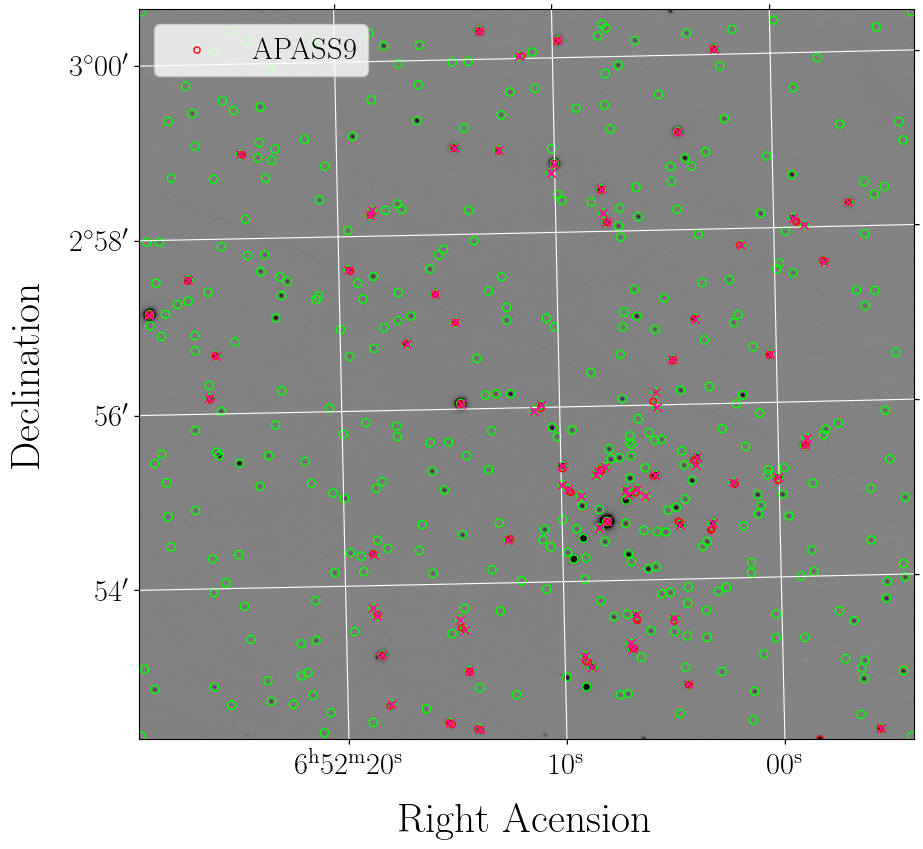

In [78]:
pixel_coords_total = []

for idx in range(0, len(test_RA)): 
    pixel_coords = Pixel_conversion(test_RA[idx], test_DEC[idx], temp_file_name)
    pixel_coords_total.append(pixel_coords)

data = fits.getdata(temp_file_name)

hdu = fits.open(temp_file_name)[0]
wcs_proj = wcs.WCS(hdu.header)
plt.subplot(projection=wcs_proj)


plt.scatter(catalog_RA_pixel, catalog_DEC_pixel, facecolor = 'none', edgecolors='red', s = 20, zorder = 3, label = 'APASS9')

for obs_coord in tar:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, facecolor = 'None', edgecolors = 'lime')

for idx in obs_index:
    obs_RA = tar[idx].ra.degree; obs_DEC = tar[idx].dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, marker = 'x', color = 'deeppink', zorder = 4)


plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg', zorder = 0)
plt.grid(color='white', ls='solid')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Right Acension'); plt.ylabel('Declination')
plt.show()

## Aperture Calibration 

In [79]:
from photutils import * 
from scipy.optimize import curve_fit
import pandas as pd

In [80]:
def aper_photometry(data, sources):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

## Linear Fitting

In [81]:
def lin_func(x, m, c):
	return m*x + c

In [85]:
obs_mag = aper_photometry(image_data, DAO_source_table[obs_index])
catalog_mag = catalog_result['Bmag'][cat_index]; catalog_mag_err = catalog_result['e_Bmag'][cat_index]

# --- Removing any NAN values --- 
nan_idx = np.argwhere(np.isnan(obs_mag))
obs_mag = np.delete(obs_mag, nan_idx); catalog_mag = np.delete(catalog_mag, nan_idx);  catalog_mag_err = np.delete(catalog_mag_err, nan_idx)


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


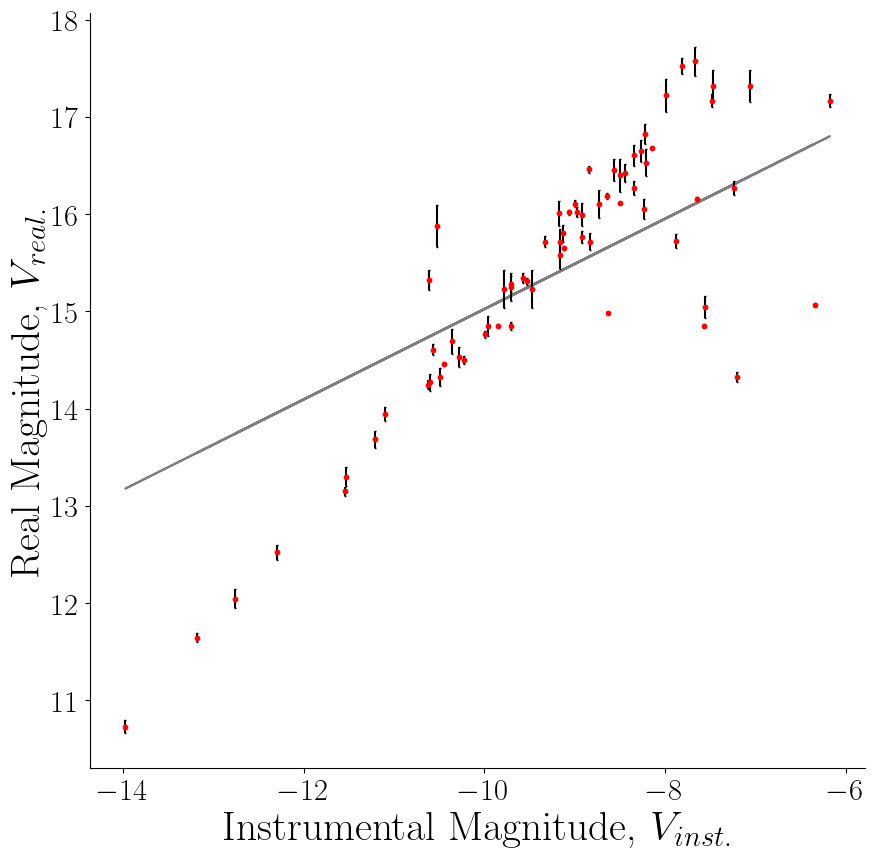

In [86]:

# --- fitting data for graph --- 
popt, pcov = curve_fit(lin_func, obs_mag, catalog_mag, sigma = (catalog_mag_err))
fit_data = lin_func(obs_mag, popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])

# Create DataFrame   
data = {'params': popt, 'param_err': [slope_err, const_err]}  
df = pd.DataFrame(data)  
df.to_csv(r'calibration_parameters/' + target_name + '.txt', index=None, sep=' ', mode='a')

plt.plot(obs_mag, fit_data, 'k-', alpha = 0.5)
plt.scatter(obs_mag, catalog_mag, s = 10, color = 'red', zorder = 3)
plt.errorbar(obs_mag, catalog_mag, yerr=catalog_mag_err, ls = 'None', capsize = .5, color = 'black')
plt.xlabel('Instrumental Magnitude, $V_{{inst.}}$'); plt.ylabel('Real Magnitude, $V_{real.}$')
plt.savefig('calibration_parameters/plots/' + target_name + '.png')
